In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.api._v2 import keras
from keras.api._v2.keras import layers
from keras.api._v2.keras import Sequential
from keras.api._v2.keras.preprocessing.image import load_img
from keras.api._v2.keras.preprocessing.image import random_shear
from keras.api._v2.keras.metrics import AUC, BinaryAccuracy
from keras.api._v2.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd

sns.set_theme()

## 0. Preparing data

Reserve 20% of training set for validation

In [2]:
data_dir = '../../data/dogs_vs_cats'
batch_size=20
img_width = 150
img_height = 150

In [4]:
class_names = []

In [5]:
with tf.device('/cpu:0'):
    train_ds = keras.utils.image_dataset_from_directory(
        f'{data_dir}/train/',
        validation_split=0.2,
        subset='training',
        seed=42,
        label_mode='binary',
        shuffle=True,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
with tf.device('/cpu:0'):
    val_ds = keras.utils.image_dataset_from_directory(
        f'{data_dir}/train/',
        validation_split=0.2,
        subset='validation',
        seed=42,
        label_mode='binary',
        shuffle=True,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [7]:
model = Sequential(
    [
        keras.layers.Input(shape=(150, 150, 3)),
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.002, momentum=0.8),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        AUC(name='auc')
    ]
)

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)
callbacks = [earlystop, learning_rate_reduction]

## Question 1
Since we have a binary classification problem, what is the best loss function for us?

Note: since we specify an activation for the output layer, we don't need to set from_logits=True

Ans. `BinaryCrossentropy`

## Question 2

What's the total number of parameters of the model? You can use the summary method for that.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 128)               22429824  
                                                                 
 dropout (Dropout)           (None, 128)               0

Ans: 11,215,873

In [10]:
with tf.device('/cpu:0'):
    preprocess_layer = keras.Sequential([
        keras.layers.Rescaling(scale=1./255)
    ])

def preprocess_input(ds):
    return ds.map(lambda x, y: (preprocess_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
history = model.fit(
    preprocess_input(train_ds),
    steps_per_epoch=100,
    epochs=10,
    validation_data=preprocess_input(val_ds),
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/10


2022-08-15 12:59:43.614501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-15 12:59:44.028313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 4.6313 - accuracy: 0.5195 - auc: 0.5297

2022-08-15 12:59:53.989131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 14s 134ms/step - loss: 4.6313 - accuracy: 0.5195 - auc: 0.5297 - val_loss: 0.6987 - val_accuracy: 0.4870 - val_auc: 0.5097 - lr: 0.0020
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.6975 - accuracy: 0.5070 - auc: 0.5104 - val_loss: 0.6928 - val_accuracy: 0.5190 - val_auc: 0.5000 - lr: 0.0020
Epoch 3/10
100/100 [==============================] - 13s 132ms/step - loss: 0.7177 - accuracy: 0.5215 - auc: 0.4875 - val_loss: 0.6925 - val_accuracy: 0.5210 - val_auc: 0.5000 - lr: 0.0020
Epoch 4/10
 46/100 [============>.................] - ETA: 5s - loss: 0.6946 - accuracy: 0.4652 - auc: 0.4749

KeyboardInterrupt: 

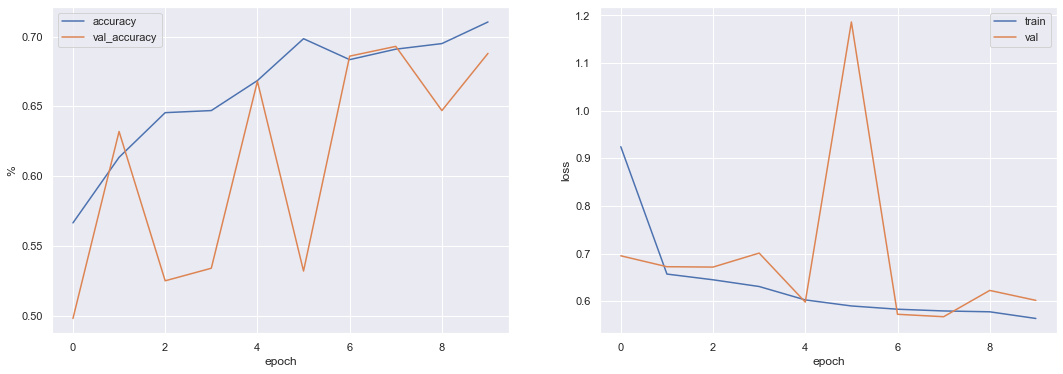

In [44]:
df_history = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
df_history.plot(y=['accuracy', 'val_accuracy'], ylabel='%', xlabel='epoch', ax=axes[0])
df_history.plot(y=['loss', 'val_loss'], ylabel='loss', xlabel='epoch', ax=axes[1])
for ax in axes:
    axes[1].legend(['train', 'val'])

## Question 3
What is the median of training accuracy for this model?

In [45]:
df_history.accuracy.mean()

0.6619500339031219

## Question 4
What is the standard deviation of training loss for this model?

In [46]:
df_history.loss.std()

0.10618293206270067

## Data augumentation

In [10]:
with tf.device('/cpu:0'):
    data_augument = keras.Sequential([
        keras.layers.RandomRotation(40, fill_mode='nearest'),
        keras.layers.RandomTranslation(0.2, 0, fill_mode='nearest'),
        keras.layers.RandomTranslation(0, 0.2, fill_mode='nearest'),
        keras.layers.RandomZoom(0.2, 0.2, fill_mode='nearest'),
        keras.layers.RandomFlip(mode='horizontal'),
        preprocess_layer
    ])

In [13]:
history = model.fit(
    train_ds.map(lambda x, y: (data_augument(x), y), num_parallel_calls=tf.data.AUTOTUNE),
    steps_per_epoch=100,
    epochs=10,
    validation_data=preprocess_input(val_ds),
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 13s 129ms/step - loss: 0.3476 - accuracy: 0.8570 - auc: 0.9284 - val_loss: 0.6374 - val_accuracy: 0.6880 - val_auc: 0.7743
Epoch 2/10
100/100 [==============================] - 13s 128ms/step - loss: 0.3403 - accuracy: 0.8505 - auc: 0.9344 - val_loss: 0.6105 - val_accuracy: 0.6850 - val_auc: 0.7623
Epoch 3/10
100/100 [==============================] - 13s 130ms/step - loss: 0.2924 - accuracy: 0.8835 - auc: 0.9530 - val_loss: 0.6933 - val_accuracy: 0.6950 - val_auc: 0.7829
Epoch 4/10
 36/100 [=========>....................] - ETA: 6s - loss: 0.3848 - accuracy: 0.8417 - auc: 0.9077

KeyboardInterrupt: 

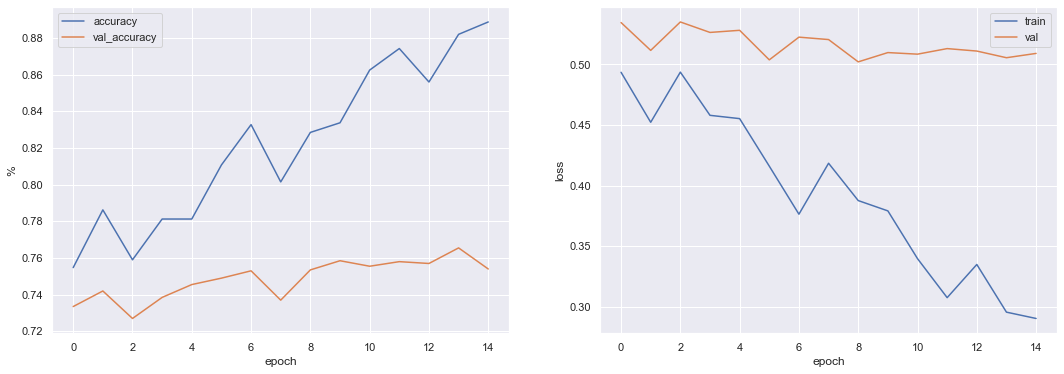

In [49]:
df_history = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
df_history.plot(y=['accuracy', 'val_accuracy'], ylabel='%', xlabel='epoch', ax=axes[0])
df_history.plot(y=['loss', 'val_loss'], ylabel='loss', xlabel='epoch', ax=axes[1])
for ax in axes:
    axes[1].legend(['train', 'val'])